# SPX Sentiment Analysis

Data source: TD Ameritrade Thinkorswim (Time and Sales)

Since there is no method that I am aware of to export Thinkorswim's Time and Sales data to Excel, the data is manually copy and pasted daily to the excel sheet: 'spx_options_timesales.xlsx'. Other sources require a subscription (i.e. $69/month), so is such the price of free market data?

The Thinkorswim Time and Sales features allows me to filter some data, which I took the liberty in the following way to remove small position sizes and low prices:

#### Option Time & Sales filter:
* Type: Calls and Puts
* Time series: Monthly Expirations from front month to next quarterly option's expiration (OpEx)
* Strikes: All
* Exchange: All
* Quantity: Lot >= 10
* Price: $ >= 10
* Condition: None selected (Spreads, Straddle, BuyWrite, Combo)


In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

df = pd.read_excel('spx_options_timesales_aug3.xlsx') # data from 8/3/2022

# today = date.today()
today = datetime.datetime(2022,8,3) # dataset's date
print("Today's date is: ", today)

df.head()

Today's date is:  2022-08-03 00:00:00


,Time,Option,Qty,Price,Exchange,Market,Delta,IV,Underlying
0,13:33:08,16 SEP 22 4150 C,118,113.90,CBOE,113.60x114.90,0.55,0.1765,4155.17
1,13:30:13,16 SEP 22 4150 P,118,111.90,CBOE,111.30x112.30,-0.45,0.2169,4155.17
2,13:29:01,21 OCT 22 4490 C,200,33.15,CBOE,32.50x33.50,0.19,0.165,4155.17
3,13:29:01,21 OCT 22 3400 P,200,19.40,CBOE,19.30x19.80,-0.07,0.3177,4155.17
4,13:29:01,21 OCT 22 3375 P,200,18.05,CBOE,17.90x18.40,-0.06,0.321,4155.17


## Data Cleaning

In [95]:
# include only trades between market hours (6:30am PST - 13:15pm PST)

market_open = pd.to_datetime('06:30:00', format='%H:%M:%S')
market_close = pd.to_datetime('13:15:00', format='%H:%M:%S')

df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

df = df[(df['Time'] >= market_open) & (df['Time'] <= market_close)]

# revert time column to original format
# df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

In [96]:
# separate bid and ask

df[['Bid','Ask']] = df['Market'].str.split('x', expand=True).astype(float)

# add mid price

df['Mid'] = (df['Bid'] + df['Ask'])/2

In [97]:
# calculate premium and total deltas

df['Premium'] = df['Qty'] * df['Price'] * 100
df['Total Delta'] = df['Qty'] * df['Delta']

In [98]:
# separate option data (expiry date, strike price, type)

df['Expiry Date'] = df['Option'].str[:9]
strike_type = df['Option'].str[10:]
df[['Strike Price','Type']] = strike_type.str.split(' ', expand = True)

In [99]:
# separate calls from puts

df_calls = df[df['Type'] == 'C']
df_puts = df[df['Type'] == 'P']

## Analysis

Sentiment is inferred by judging whether an order is purchased above or below market (midpoint between bid and ask). If the option was traded above market, then it is considered bought. If the option was traded below market, then it is considered sold. If the option was traded exactly at market price, then it is unclear whether it was bought or sold and is left out of this analysis. 

In [100]:
# differentiate between option buying vs option selling

# calls bought and sold

df_cbot = df_calls[df_calls['Price'] > df_calls['Mid']]
df_csold = df_calls[df_calls['Price'] < df_calls['Mid']]

# puts bought and sold

df_pbot = df_puts[df_puts['Price'] > df_puts['Mid']]
df_psold = df_puts[df_puts['Price'] < df_puts['Mid']]

In [101]:
# Divide options traded among near term, next quarterly OpEx, and end of day (EOD)

# Gather the months from the data

calendar = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
winter = ['DEC','JAN']
calendar2 = ['NOV','DEC','JAN','FEB','MAR']

for snow in winter:
    if df['Expiry Date'].str.contains(snow).all():
        months = [month for month in calendar2 if df['Expiry Date'].str.contains(month).any()]
    else:
        months = [month for month in calendar if df['Expiry Date'].str.contains(month).any()]
        
# Locate the two front month expirations

front_month = months[0]
next_month = months[1]

# front month calls bought and sold

df_cbot_fm = df_cbot[df_cbot['Expiry Date'].str.contains(front_month)]
df_csold_fm = df_csold[df_csold['Expiry Date'].str.contains(front_month)]

# front month bought and sold

df_pbot_fm = df_pbot[df_pbot['Expiry Date'].str.contains(front_month)]
df_psold_fm = df_psold[df_psold['Expiry Date'].str.contains(front_month)]

# next month calls bought and sold

df_cbot_nm = df_cbot[df_cbot['Expiry Date'].str.contains(next_month)]
df_csold_nm = df_csold[df_csold['Expiry Date'].str.contains(next_month)]

# next month bought and sold

df_pbot_nm = df_pbot[df_pbot['Expiry Date'].str.contains(next_month)]
df_psold_nm = df_psold[df_psold['Expiry Date'].str.contains(next_month)]

In [102]:
# next quarterly Opex 

OpEx = ['MAR','JUN','SEP','DEC']

# check if the last month in the data falls on a quarterly OpEx
if any(months[-1] == ex for ex in OpEx) == False:
    print('Quarterly OpEx month is invalid')
    quit()
    
# Locate the two further month expirations
far_month = months[2:]

# further term calls bought and sold

df_cbot_ft = df_cbot[df_cbot['Expiry Date'].str.contains('|'.join(far_month))]
df_csold_ft = df_csold[df_csold['Expiry Date'].str.contains('|'.join(far_month))]

# further term puts bought and sold

df_pbot_ft = df_pbot[df_pbot['Expiry Date'].str.contains('|'.join(far_month))]
df_psold_ft = df_psold[df_psold['Expiry Date'].str.contains('|'.join(far_month))]

In [103]:
# isolate EOD contracts (last 20 minutes)

# EOD calls bought and sold

df_cbot_eod = df_cbot[df_cbot['Time'] >= pd.to_datetime('12:55:00', format='%H:%M:%S')]
df_csold_eod = df_csold[df_csold['Time'] >= pd.to_datetime('12:55:00', format='%H:%M:%S')]

# puts bought/sold

df_pbot_eod = df_pbot[df_pbot['Time'] >= pd.to_datetime('12:55:00', format='%H:%M:%S')]
df_psold_eod = df_psold[df_psold['Time'] >= pd.to_datetime('12:55:00', format='%H:%M:%S')]

In [104]:
# calculate option market sentiment

# front month 

fm_sums = [df_cbot_fm['Total Delta'].sum(), df_csold_fm['Total Delta'].sum(), -df_pbot_fm['Total Delta'].sum(),
           -df_psold_fm['Total Delta'].sum()]
fm_total = sum(fm_sums)
fm_ratio = [(fm_sums[i] / fm_total * 100).round(1) for i in range(4)]

# next month

nm_sums = [df_cbot_nm['Total Delta'].sum(), df_csold_nm['Total Delta'].sum(), -df_pbot_nm['Total Delta'].sum(), 
           -df_psold_nm['Total Delta'].sum()]
nm_total = sum(nm_sums)
nm_ratio = [(nm_sums[i] / nm_total * 100).round(1) for i in range(4)]

# months till next quarterly OpEx

ft_sums = [df_cbot_ft['Total Delta'].sum(), df_csold_ft['Total Delta'].sum(), -df_pbot_ft['Total Delta'].sum(), 
           -df_psold_ft['Total Delta'].sum()]
ft_total = sum(ft_sums)
ft_ratio = [(ft_sums[i] / ft_total * 100).round(1) for i in range(4)]

# months till next quarterly OpEx

eod_sums = [df_cbot_eod['Total Delta'].sum(), df_csold_eod['Total Delta'].sum(), -df_pbot_eod['Total Delta'].sum(), 
            -df_psold_eod['Total Delta'].sum()]
eod_total = sum(eod_sums)
eod_ratio = [(eod_sums[i] / eod_total * 100).round(1) for i in range(4)]

print('Key: [Calls Bought, Calls Sold, Puts Bought, Puts Sold]\n{}: {}\n{}: {}\n{}: {}\nEOD: {}'.format(
    front_month, fm_ratio, next_month, nm_ratio, months[2] + '-' + months[-1], ft_ratio, eod_ratio))

Key: [Calls Bought, Calls Sold, Puts Bought, Puts Sold]
AUG: [33.6, 38.2, 13.5, 14.6]
SEP: [8.4, 56.1, 24.2, 11.3]
OCT-DEC: [44.3, 43.5, 7.0, 5.3]
EOD: [4.0, 70.6, 20.1, 5.3]


In [105]:
# near term put premium summary calculations

pbot = df_pbot_fm['Premium'].sum() + df_pbot_nm['Premium'].sum()
psold = df_psold_fm['Premium'].sum() + df_psold_nm['Premium'].sum()

psum = (pbot + psold).astype('int64')
pperbot = (pbot / psum * 100).round(1)
ppersold = (psold / psum * 100).round(1)

print('Total Premium: ${}\nBought: {}%\nSold: {}%'.format(psum, pperbot, ppersold))

Total Premium: $125765199
Bought: 61.8%
Sold: 38.2%


## Visualization

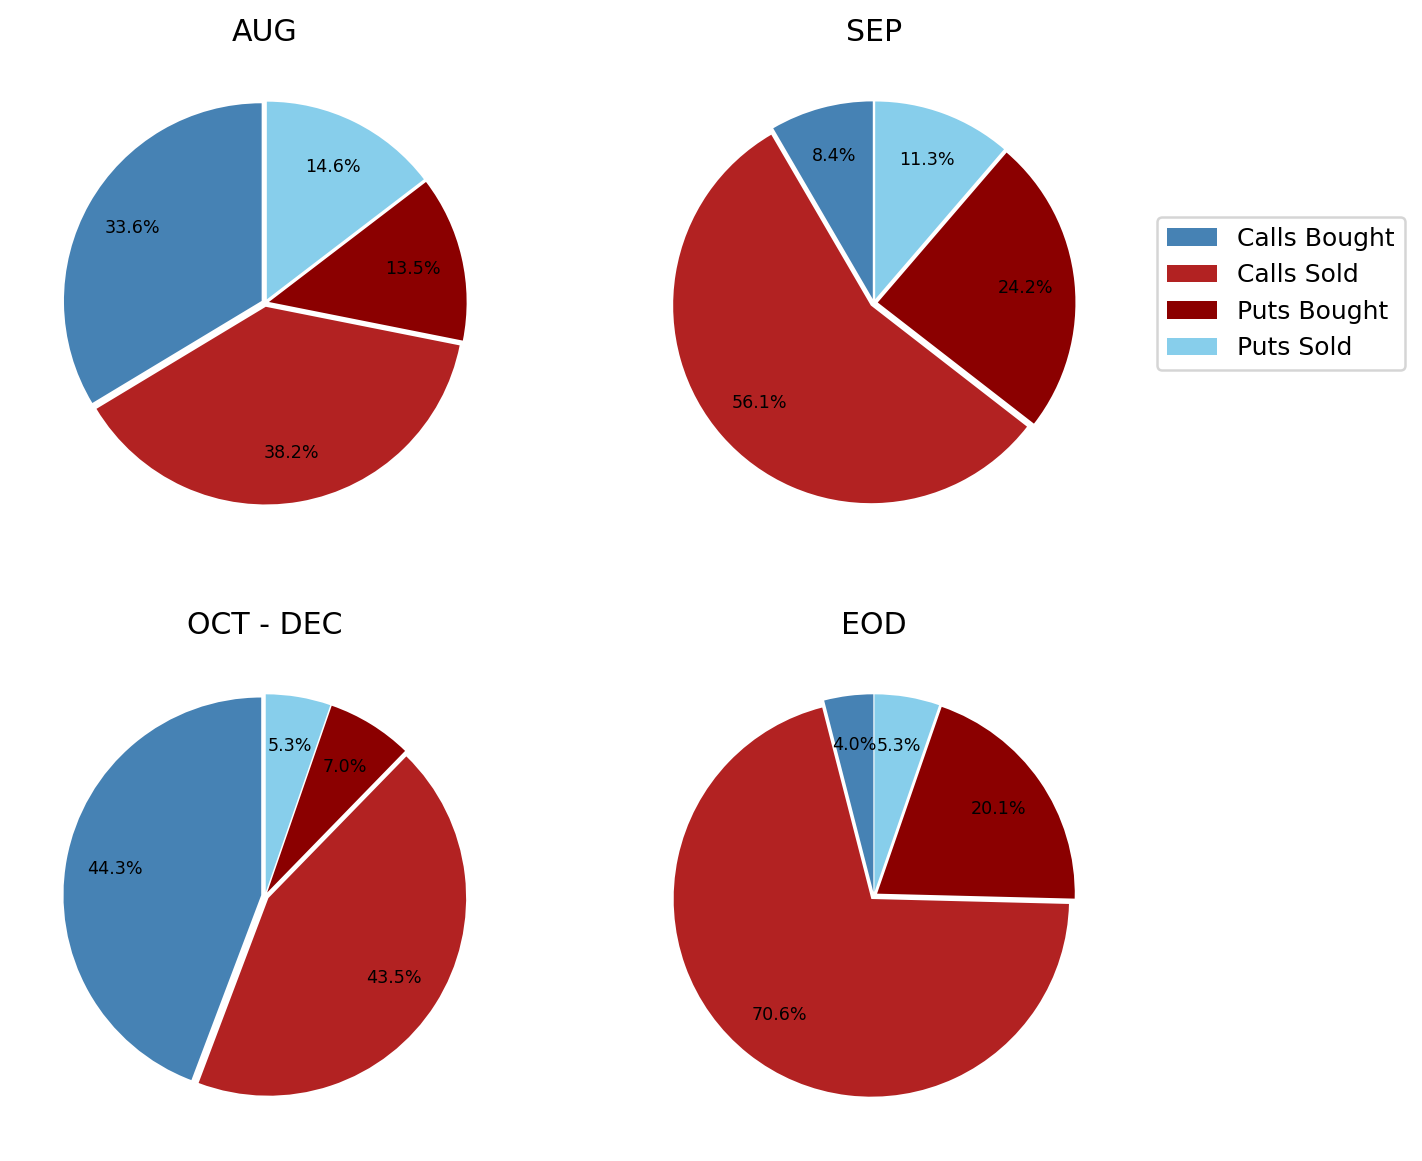

In [106]:
%matplotlib inline

labels = 'Calls Bought', 'Calls Sold', 'Puts Bought', 'Puts Sold'
colors = ['steelblue','firebrick','darkred','skyblue']
explode = [0.02, 0.02, 0.02, 0.02]

fig,ax = plt.subplots(2, 2, figsize = (8,8), dpi = 180)

ax[0,0].pie(fm_ratio, explode = explode, colors = colors, autopct = '%1.1f%%', startangle=90, pctdistance=0.75, textprops={'fontsize': 7})
ax[0,0].set_title(front_month)

ax[0,1].pie(nm_ratio, explode = explode, colors = colors, autopct = '%1.1f%%', startangle=90, pctdistance=0.75, textprops={'fontsize': 7})
ax[0,1].set_title(next_month)

ax[1,0].pie(ft_ratio, explode = explode, colors = colors, autopct = '%1.1f%%', startangle=90, pctdistance=0.75, textprops={'fontsize': 7})
ax[1,0].set_title(months[2] + ' - ' + months[-1])

ax[1,1].pie(eod_ratio, explode = explode, colors = colors, autopct = '%1.1f%%', startangle=90, pctdistance=0.75, textprops={'fontsize': 7})
ax[1,1].set_title('EOD')

plt.legend(labels, bbox_to_anchor=(1.6,1.9))

plt.show()

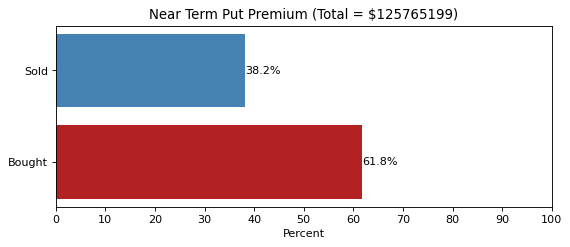

In [107]:
fig1, ax1 = plt.subplots(figsize = (8,3), dpi = 80)

hbar = ax1.barh(['Bought', 'Sold'], [pperbot, ppersold], color = ['firebrick','steelblue'])
ax1.set_title('Near Term Put Premium (Total = $' + str(psum) + ')')
ax1.set_xlabel('Percent')
ax1.bar_label(hbar, fmt = '%1.1f%%')
ax1.xaxis.set_ticks(np.arange(0, 110, 10))

plt.show()

## Conclusion

From the graphics, we can infer the following: 
* Greater call option purchases than puts (short term bullish)
* Aug-Sep saw significant call writing with Sep put purchasing (short term bearish)
* EOD: traders are shedding their calls and purchasing puts as insurance (bearish)

In short, end of day hedging activity may mark the end of this week's bullish run. Until August 19, it is possible for the bullish trend to continue, since more calls were bought today than yesterday. However, bearish option sentiment for the September expiry predicts potential headwinds coming soon. While call buying dominated in the October through December monthlies today, bearish option traders were more prevalent in the past week. Meanwhile the near term put premium chart does not illustrate market fragility. Puts purchased reduce the likelihood of develeraging, which are stabilzing market forces. Once puts bought is near equal to puts sold, the market is more at risk.

### Limitations

The major limitation of this analysis is determining whether an option is bought or sold. Deciding whether an option is purchased or written depending on its trade price relative to the bid and ask is too simple of a methodology. For example, a call filled at the bid may not be a sell but rather a limit buy order. 

Another limitation is that this analysis cannot determine the reason behind an option trade. With this method, it is impossible to tell whether an option trade is to exit a position, add to a position, or part of a complex strategy.

Thus, this sentiment inference indicator cannot be solely used for stock market analysis, but rather as another tool in the toolbox. 

Despite these restrictions, using this to have a peek behind the curtains is still better than continuing to meander blindly through the labyrinth that is the market.  